In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [ ]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_ua_license_plate.xml')
# add the path to 'india_license_plate.xml' file.

In [ ]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.4, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x-15,y), (x+w-3, y+h-5), (179, 206, 226), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (179, 206, 226), 1, cv2.LINE_AA)

    return plate_img, plate # returning the processed image.

In [ ]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,7))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('/content/drive/MyDrive/foto_avto/ka7777ca.jpg')
# display(img, 'input image')

In [ ]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

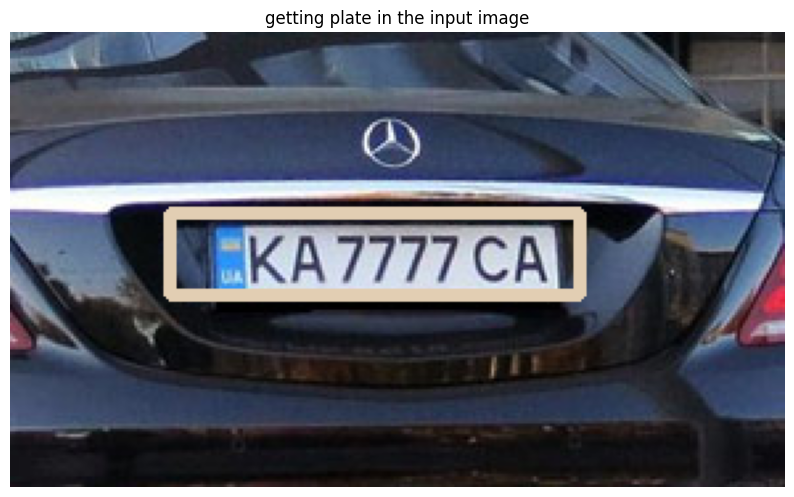

In [ ]:
display(output_img, 'getting plate in the input image')

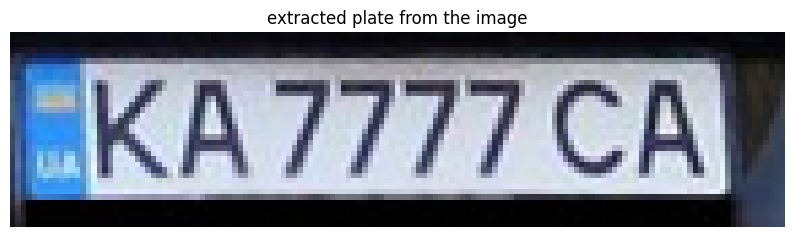

In [ ]:
display(plate, 'extracted plate from the image')

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (76, 202, 102), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

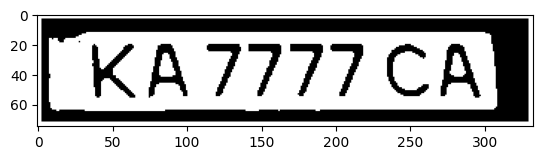

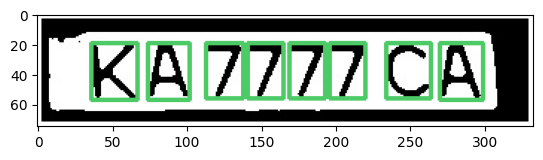

In [ ]:
# Let's see the segmented characters
char = segment_characters(plate)

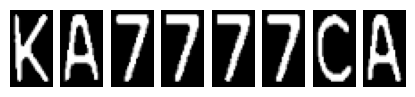

In [ ]:
for i in range(min(len(char), 10)):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# Create ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.05, height_shift_range=0.05)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/train',
        target_size=(28,28),
        batch_size=32,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/val',
        target_size=(28,28),
        batch_size=32,
        class_mode='categorical')

# Define stop training callback
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc > 0.992:
            self.model.stop_training = True

# Define TensorBoard callback
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create model
model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), input_shape=(28, 28, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=36, activation='softmax') # Change units to match the number of classes in your dataset
])

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model
batch_size = 32
callbacks = [tensorboard_callback, stop_training_callback()]
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // batch_size,
          epochs=100,
          callbacks=callbacks)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Epoch 1/100
27/27 [==============================] - 9s 280ms/step - loss: 3.5909 - accuracy: 0.0185 - val_loss: 3.5598 - val_accuracy: 0.0417
Epoch 2/100
27/27 [==============================] - 7s 270ms/step - loss: 3.5390 - accuracy: 0.0648 - val_loss: 3.5210 - val_accuracy: 0.1094
Epoch 3/100
27/27 [==============================] - 7s 268ms/step - loss: 3.4829 - accuracy: 0.1273 - val_loss: 3.4570 - val_accuracy: 0.1615
Epoch 4/100
27/27 [==============================] - 7s 262ms/step - loss: 3.4123 - accuracy: 0.1771 - val_loss: 3.3679 - val_accuracy: 0.2240
Epoch 5/100
27/27 [==============================] - 8s 287ms/step - loss: 3.2958 - accuracy: 0.2812 - val_loss: 3.2312 - val_accuracy: 0.2917
Epoch 6/100
27/27 [==============================] - 9s 339ms/step - loss: 3.1221 - accuracy: 0.3750 - val_loss: 2.9961 - val_accuracy: 0.4688
Epoch 7/100
27/27 [==============================] - 7s 23

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(validation_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


7/7 [==============================] - 2s 209ms/step - loss: 0.0342 - accuracy: 0.9954
Test Loss: 0.03415423259139061
Test Accuracy: 0.9953703880310059


In [ ]:
# Зберегти модель у форматі native Keras
model.save("model.keras")


In [ ]:
# Predicting the output
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char): # ітеруємося по символах
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3) # підготовка зображення для моделі
        y_proba = model.predict(img, verbose=0)[0] # отримуємо ймовірності для кожного класу
        y_ = np.argmax(y_proba) # вибираємо клас з найвищою ймовірністю
        character = dic[y_] # отримуємо символ, відповідний прогнозованому класу
        output.append(character) # зберігаємо результат у списку

    plate_number = ''.join(output) # об'єднуємо всі символи у рядок

    return plate_number

print(show_results(char))


KA7777CA


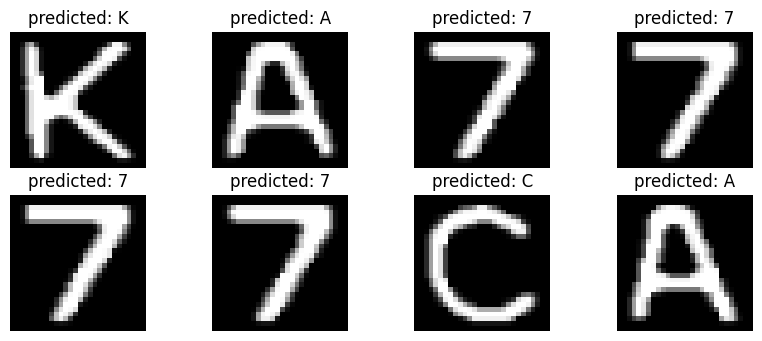

In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    predicted_char = show_results(char)[i]  # виконати передбачення перед виведенням
    plt.title(f'predicted: {predicted_char}') # передавання char як аргументу
    plt.axis('off')
plt.show()
